Testing for an audio processing feature, based on Audacity's noise reduction and loudness normalization features.

In [1]:
#relative path finder 
import os

def pathfinder (base_path, target_path):
    relative_path = os.path.relpath(target_path, start=os.path.dirname(base_path))
    return relative_path



base_path = r"G:\Cloned Repos\Repo prueba 1\Binary-class\NoiseFilteringTest\NoiseFiltering.ipynb"
target_path = r"G:\Cloned Repos\Repo prueba 1\Binary-class\Dataset-custom-audio\audio-standby-files\noise-profile\Noise.wav"

path=pathfinder(base_path, target_path)
print(path)


..\Dataset-custom-audio\audio-standby-files\noise-profile\Noise.wav


# Step One: Normalization

For this section, we will use ffmpeg-normalize. More information [here](https://pypi.org/project/ffmpeg-normalize/).

In [2]:
import ffmpeg_normalize as normalizer
import torch

In [3]:
# For this and for denoiser, we'll use the same settings used in Audacity.
normalize = normalizer.FFmpegNormalize(normalization_type='ebu', target_level=-23, dual_mono=True, print_stats=True)
normalize.add_media_file("../Dataset-custom-audio/test-audio-not-split/010123.wav", "Normalized-010123.wav")
normalize.run_normalization()

You specified linear normalization, but the loudnorm filter reverted to dynamic normalization. This may lead to unexpected results.Consider your input settings, e.g. choose a lower target level or higher target loudness range.


[
    {
        "input_file": "../Dataset-custom-audio/test-audio-not-split/010123.wav",
        "output_file": "Normalized-010123.wav",
        "stream_id": 0,
        "ebu_pass1": {
            "input_i": -46.01,
            "input_tp": -23.21,
            "input_lra": 1.3,
            "input_thresh": -56.01,
            "output_i": -22.83,
            "output_tp": -2.0,
            "output_lra": 0.8,
            "output_thresh": -32.83,
            "normalization_type": "dynamic",
            "target_offset": -0.17
        },
        "ebu_pass2": {
            "input_i": -46.01,
            "input_tp": -23.21,
            "input_lra": 1.3,
            "input_thresh": -56.01,
            "output_i": -23.0,
            "output_tp": -2.0,
            "output_lra": 0.8,
            "output_thresh": -33.0,
            "normalization_type": "dynamic",
            "target_offset": -0.0
        },
        "mean": null,
        "max": null
    }
]


# Step Two: Noise Reduction

Based on Audacity's noise reduction, using noisereduce. More information [here](https://pypi.org/project/noisereduce/).


In [4]:
# Remove this comment to install noisereduce if needed
#%pip install noisereduce

In [5]:
import noisereduce as nr
from scipy.io import wavfile

#setting up device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"


In [6]:
# obtain normalized file
rate_normal, data_normal = wavfile.read("Normalized-010123.wav")

In [6]:
device

'cuda'

## Stationary Noise

Stationary Noise Reduction acts on noise that is stationary in intensity and shape over time, like the hum of electronics.

In [7]:
# Noise Reduction: 16 dB. Sensitivity: 2.0. Frequency smoothing bands: 12

#perform noise reduction
reduced_noise = nr.reduce_noise(y=data_normal, sr=rate_normal, stationary=True, prop_decrease=2.0, freq_mask_smooth_hz=375,device=device)
wavfile.write("reduced_noise_stat.wav", rate_normal, reduced_noise)

## Non-stationary Noise

Non-stationary noise reduction targets background noise that is non-stationary and fluctuates over time, like the presence of an airplane flying overhead.

In [8]:
# Noise Reduction: 16 dB. Sensitivity: 2.0. Frequency smoothing bands: 12

noise_rate, noise_data = wavfile.read("../Dataset-custom-audio/audio-standby-files/noise-profile/Noise.wav") # noise profile, pre-normalized

#perform noise reduction
reduced_noise = nr.reduce_noise(y=data_normal, sr=rate_normal, y_noise=noise_data, stationary=False, prop_decrease=2.0, freq_mask_smooth_hz=375,device=device)
wavfile.write("reduced_noise_nonstat.wav", rate_normal, reduced_noise)

C:\Users\Kat\AppData\Local\Temp\ipykernel_160952\3515032385.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  noise_rate, noise_data = wavfile.read("../Dataset-custom-audio/audio-standby-files/noise-profile/Noise.wav") # noise profile, pre-normalized


## Graphs

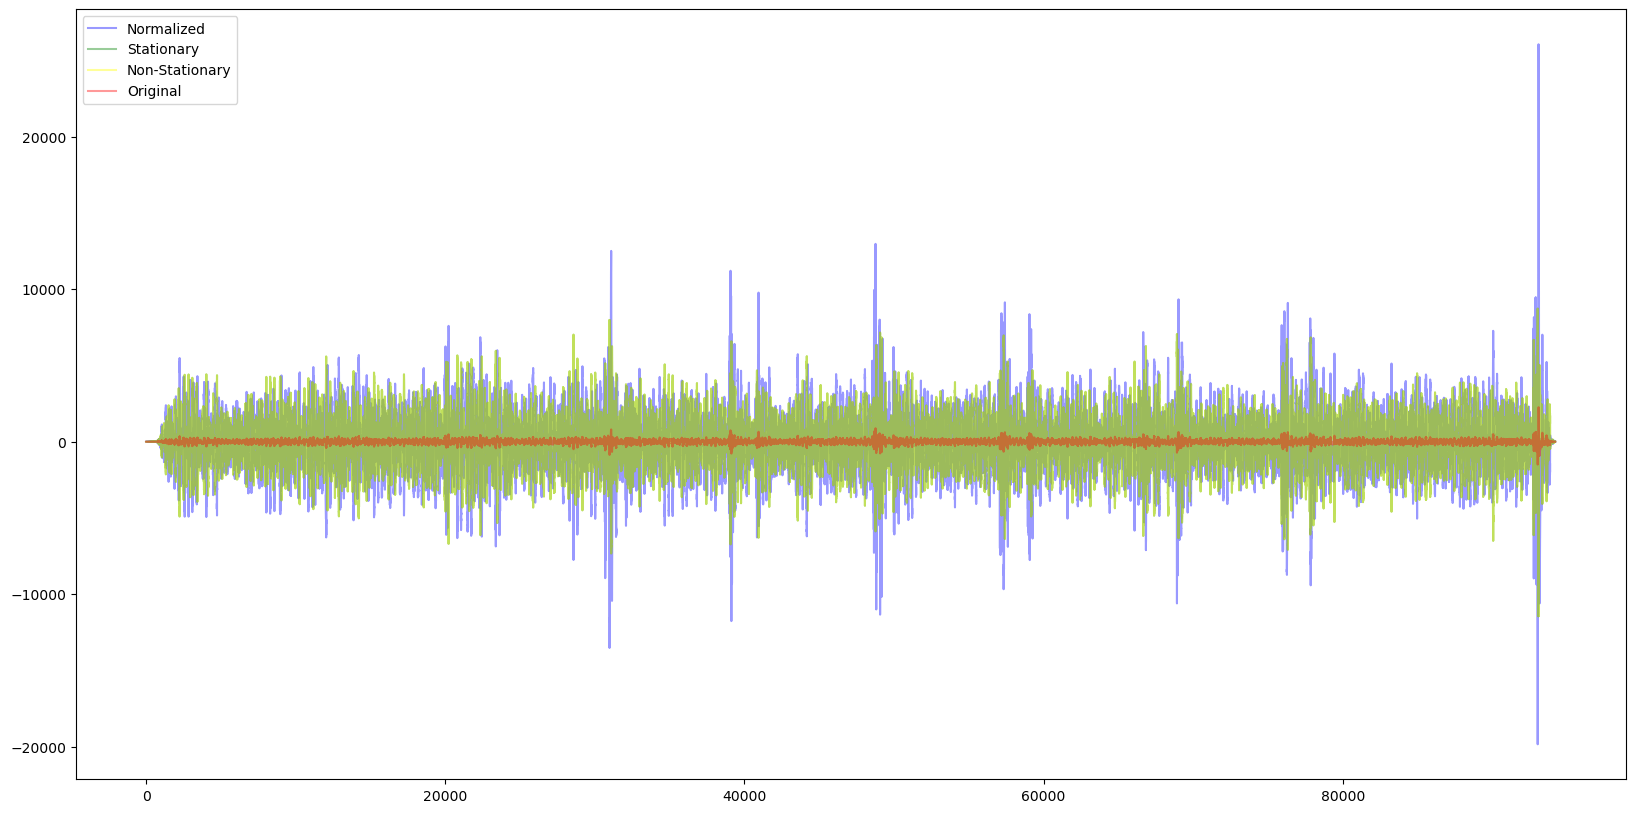

In [17]:
import matplotlib.pyplot as plt
from scipy.signal import resample

plt.figure(figsize=(20,10))
common_rate = 16000 #common sample rate for graphing

#graph normalized
data_normal_resampled = resample(data_normal, int(len(data_normal)*common_rate/rate_normal))
plt.plot(data_normal_resampled, label="Normalized", color="blue", alpha=0.4)

#graph stationary
_, data_stat = wavfile.read("reduced_noise_stat.wav")
data_stat_resampled = resample(data_stat, int(len(data_stat)*common_rate/_))
plt.plot(data_stat_resampled, label="Stationary", color="green", alpha=0.4)

#graph nonstationary
_, data_nonstat = wavfile.read("reduced_noise_stat.wav")
data_nonstat_resampled = resample(data_stat, int(len(data_stat)*common_rate/_))
plt.plot(data_nonstat_resampled, label="Non-Stationary", color="yellow", alpha=0.4)

#og
_,data_og = wavfile.read("../Dataset-custom-audio/test-audio-not-split/010123.wav")
#resampling with others' rate
data_og_resampled = resample(data_og, int(len(data_og)*common_rate/_))
plt.plot(data_og_resampled, label="Original", color="red", alpha=0.4)

plt.legend()
plt.show()